In [52]:
from FLD_methods import *
import os

In [53]:
scope_crops = '/Users/jameswallace/Desktop/SCOPE_crops' # get the folder containing the SCOPE sims

In [54]:
from glob import glob
folders = glob("/Users/jameswallace/Desktop/SCOPE_crops/*/")  

In [55]:
# get the correct files
def get_spectra_pathnames(dir_pathname):
    folders = glob(dir_pathname + '/*/')
    e_pathnames, l_pathnames, f_pathnames = [], [], []
    for sub_dir in folders:
        e_pathnames.append(sub_dir + 'Esun.csv')
        l_pathnames.append(sub_dir + 'Lo_spectrum_inclF.csv')
        f_pathnames.append(sub_dir + 'fluorescence_scalars.csv')
    return(e_pathnames, l_pathnames, f_pathnames)

In [56]:
e_pathnames, l_pathnames, f_pathnames = get_spectra_pathnames(scope_crops)

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_unstressed_bean/Lo_spectrum_inclF.csv


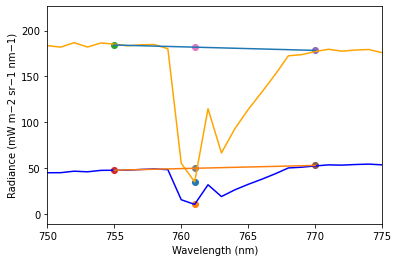

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_wheat/Lo_spectrum_inclF.csv


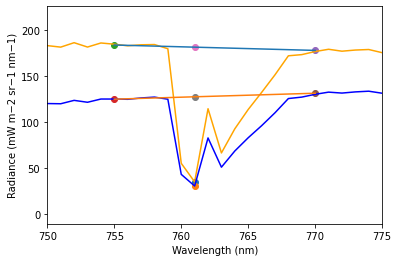

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_unstressed_bean/Lo_spectrum_inclF.csv


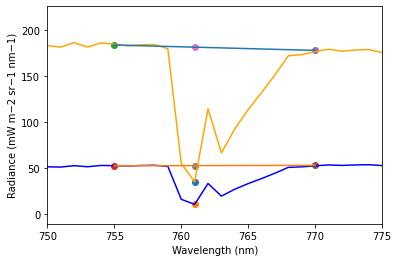

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_bean/Lo_spectrum_inclF.csv


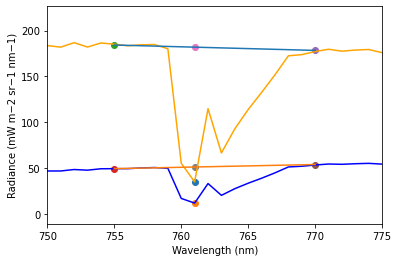

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_stressed_wheat/Lo_spectrum_inclF.csv


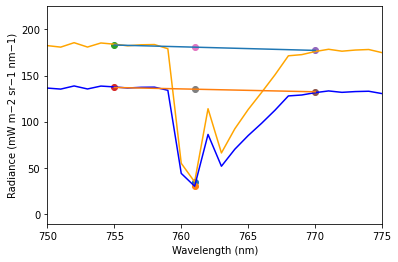

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_stressed_bean/Lo_spectrum_inclF.csv


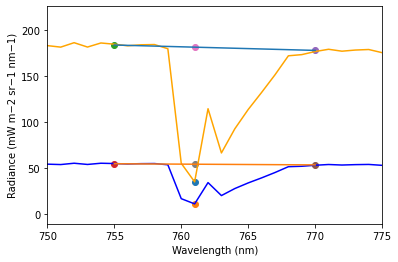

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_unstressed_wheat/Lo_spectrum_inclF.csv


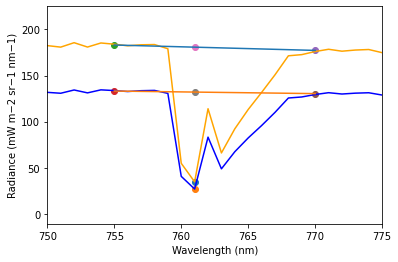

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_unstressed_bean/Lo_spectrum_inclF.csv


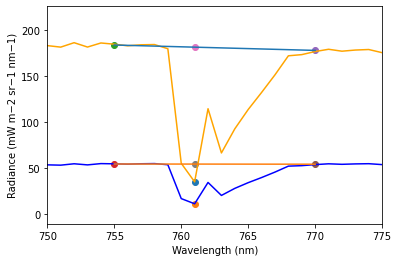

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_unstressed_wheat/Lo_spectrum_inclF.csv


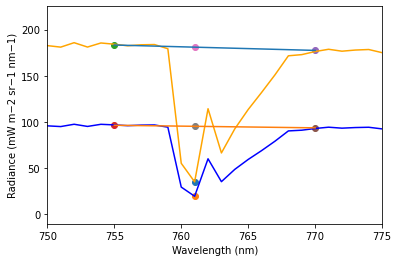

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_stressed_wheat/Lo_spectrum_inclF.csv


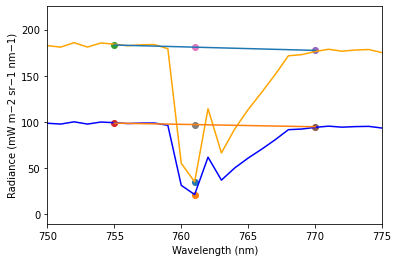

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_unstressed_wheat/Lo_spectrum_inclF.csv


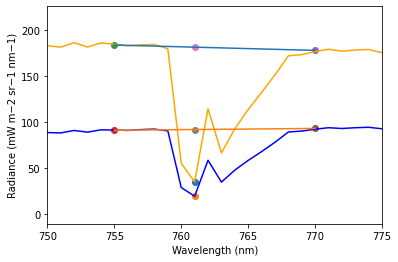

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_stressed_bean/Lo_spectrum_inclF.csv


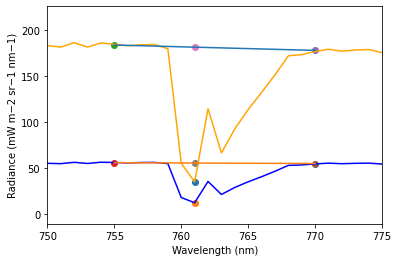

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_unstressed_wheat/Lo_spectrum_inclF.csv


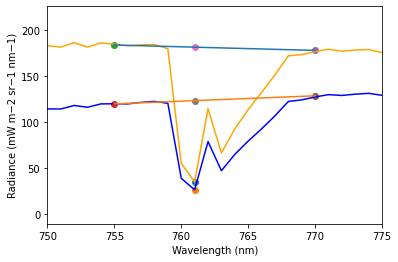

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_stressed_bean/Lo_spectrum_inclF.csv


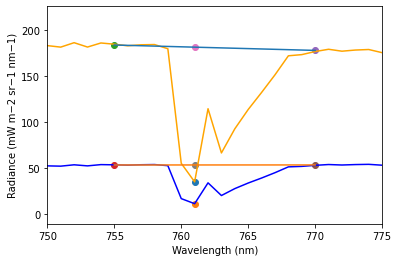

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_unstressed_bean/Lo_spectrum_inclF.csv


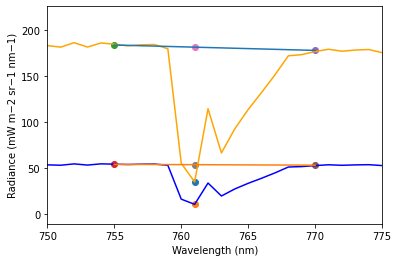

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_stressed_wheat/Lo_spectrum_inclF.csv


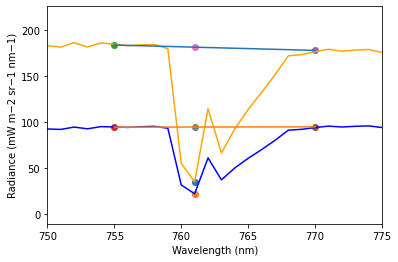

In [57]:
# get the spectras from the files and apply the sFLD
retrieved_flourescence = []
actual_fluorescence = []
retrieved_convoluted_fluorescence = []
three_fld_retrieved = []
three_fld_convoluted = []

for i in range(len(e_pathnames)):
    print(l_pathnames[i])
    # get the E and L spectra
    e_spectra = get_simulated_spectral_df(e_pathnames[i])
    l_spectra = get_simulated_spectral_df(l_pathnames[i])
    e_spectra = np.asarray(e_spectra.iloc[0])
    l_spectra = np.asarray(l_spectra.iloc[0])
    
    resampled_e_spectra, re_wave = resample_spectra(fwhm = 3.5, spectra = e_spectra)
    resampled_l_spectra = resample_spectra(fwhm=3.5, spectra = l_spectra)[0]
    
    # apply the sFLD method
    retrieved_flourescence.append(sFLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, plot = False))
    retrieved_convoluted_fluorescence.append(sFLD(resampled_e_spectra, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False))
    three_fld_retrieved.append(three_FLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1))
    three_fld_convoluted.append(three_FLD(resampled_e_spectra / np.pi, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False))
    
    # get actual F
    f_df = pd.read_csv(f_pathnames[i])
    f_df = f_df.iloc[2:]
    f_df.index = [0]
    f_761 = pd.to_numeric(f_df['F761'])
    actual_fluorescence.append(f_761.iloc[0])

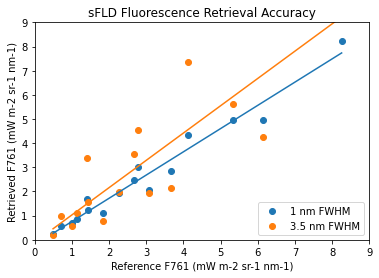

In [58]:
# produce basic plot
plt.scatter(actual_fluorescence, retrieved_flourescence, label = '1 nm FWHM')
plt.scatter(actual_fluorescence, retrieved_convoluted_fluorescence, label = '3.5 nm FWHM')
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_flourescence, 1))(np.unique(actual_fluorescence)))
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_convoluted_fluorescence, 1))(np.unique(actual_fluorescence)))
plt.xlabel('Reference F761 (mW m-2 sr-1 nm-1)')
plt.ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.title('sFLD Fluorescence Retrieval Accuracy')
plt.legend(loc = 'lower right')

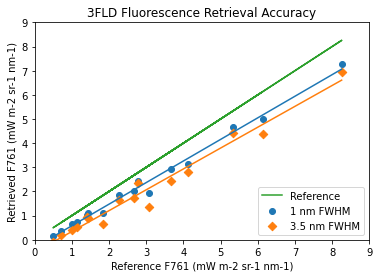

In [59]:
# produce basic plot
plt.scatter(actual_fluorescence, three_fld_retrieved, label = '1 nm FWHM')
plt.scatter(actual_fluorescence, three_fld_convoluted, label = '3.5 nm FWHM', marker = 'D')
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_retrieved, 1))(np.unique(actual_fluorescence)))
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_convoluted, 1))(np.unique(actual_fluorescence)))
plt.plot(actual_fluorescence, actual_fluorescence, label = 'Reference')
plt.xlabel('Reference F761 (mW m-2 sr-1 nm-1)')
plt.ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.title('3FLD Fluorescence Retrieval Accuracy')
plt.legend(loc='lower right')

In [60]:
# now calculate quality of fit statistics

def rmse(y_actual, y_predicted):
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
    RMSE = np.sqrt(MSE)
    return(RMSE)

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(actual_fluorescence, retrieved_flourescence)
    

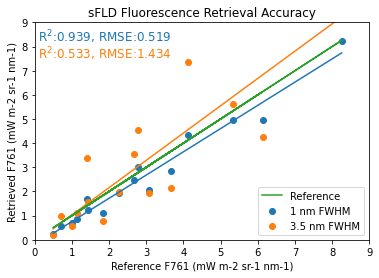

In [61]:
# produce basic plot
plt.scatter(actual_fluorescence, retrieved_flourescence, label = '1 nm FWHM')
plt.scatter(actual_fluorescence, retrieved_convoluted_fluorescence, label = '3.5 nm FWHM')
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_flourescence, 1))(np.unique(actual_fluorescence)))
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_convoluted_fluorescence, 1))(np.unique(actual_fluorescence)))
plt.plot(actual_fluorescence, actual_fluorescence, label = 'Reference')
plt.xlabel('Reference F761 (mW m-2 sr-1 nm-1)')
plt.ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.title('sFLD Fluorescence Retrieval Accuracy')
plt.text(x = 0.1, y = 8.2, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, retrieved_flourescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_flourescence), 3)), color = '#1f77b4', fontsize = 12)
plt.text(x = 0.1, y = 7.5, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, retrieved_convoluted_fluorescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_convoluted_fluorescence), 3)), color = 'C1', fontsize = 12)


plt.legend(loc = 'lower right')

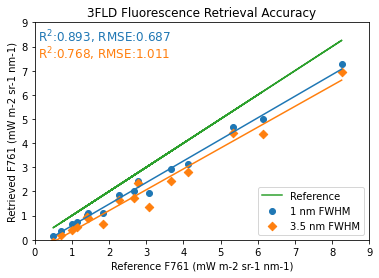

In [62]:
# produce basic plot
plt.scatter(actual_fluorescence, three_fld_retrieved, label = '1 nm FWHM')
plt.scatter(actual_fluorescence, three_fld_convoluted, label = '3.5 nm FWHM', marker = 'D')
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_retrieved, 1))(np.unique(actual_fluorescence)))
plt.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_convoluted, 1))(np.unique(actual_fluorescence)))
plt.plot(actual_fluorescence, actual_fluorescence, label = 'Reference')
plt.xlabel('Reference F761 (mW m-2 sr-1 nm-1)')
plt.ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.title('3FLD Fluorescence Retrieval Accuracy')

plt.text(x = 0.1, y = 8.2, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, three_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
plt.text(x = 0.1, y = 7.5, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, three_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_convoluted), 3)), color = 'C1', fontsize = 12)

plt.legend(loc='lower right')

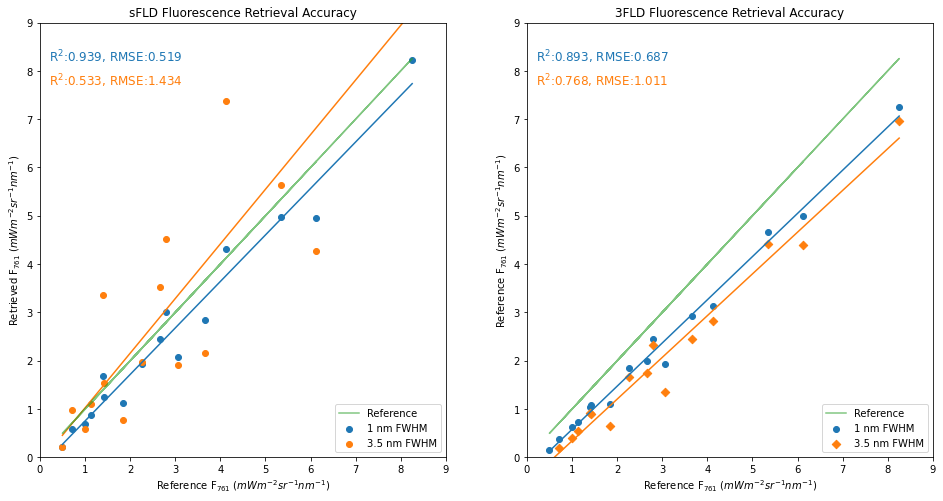

In [63]:
# now plot next to eachother

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

# plot sFLD results
ax1.scatter(actual_fluorescence, retrieved_flourescence, label = '1 nm FWHM')
ax1.scatter(actual_fluorescence, retrieved_convoluted_fluorescence, label = '3.5 nm FWHM')
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_flourescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_convoluted_fluorescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6)
ax1.set_xlabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_ylabel('Retrieved F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_xlim(0, 9)
ax1.set_ylim(0, 9)
ax1.set_title('sFLD Fluorescence Retrieval Accuracy')
ax1.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, retrieved_flourescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_flourescence), 3)), color = '#1f77b4', fontsize = 12)
ax1.text(x = 0.2, y = 7.7, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, retrieved_convoluted_fluorescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_convoluted_fluorescence), 3)), color = 'C1', fontsize = 12)
ax1.legend(loc = 'lower right')

# plot 3FLD results
# produce basic plot
ax2.scatter(actual_fluorescence, three_fld_retrieved, label = '1 nm FWHM')
ax2.scatter(actual_fluorescence, three_fld_convoluted, label = '3.5 nm FWHM', marker = 'D')
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_retrieved, 1))(np.unique(actual_fluorescence)))
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_convoluted, 1))(np.unique(actual_fluorescence)))
ax2.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6)
ax2.set_xlabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax2.set_ylabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax2.set_xlim(0, 9)
ax2.set_ylim(0, 9)
ax2.set_title('3FLD Fluorescence Retrieval Accuracy')

ax2.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, three_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
ax2.text(x = 0.2, y = 7.7, s = 'R$^2$:' + str(round(r2_score(actual_fluorescence, three_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_convoluted), 3)), color = 'C1', fontsize = 12)

ax2.legend(loc='lower right')

In [64]:
# now plot relative error box and whisker

# calculate percentage errors of each array
# plot the box plots for the two FWHM for the sFLD and 3FLD methods

# relative_error = |(actual - expected) / expected| * 100 

def relative_error(retrieved, expected):
    error = (retrieved - expected) / expected
    rel_error = np.abs(error) * 100
    return(rel_error)

In [65]:
retrieved_flourescence[0]
actual_fluorescence[0]

1.396098

In [66]:
sfld_rel_error = []
sfld_conv_rel_error = []
three_rel_error = []
three_conv_rel_error = []
for i in range(len(retrieved_flourescence)):
    sfld_rel_error.append(relative_error(retrieved_flourescence[i], actual_fluorescence[i]))
    sfld_conv_rel_error.append(relative_error(retrieved_convoluted_fluorescence[i], actual_fluorescence[i]))
    three_rel_error.append(relative_error(three_fld_retrieved[i], actual_fluorescence[i]))
    three_conv_rel_error.append(relative_error(three_fld_convoluted[i], actual_fluorescence[i]))

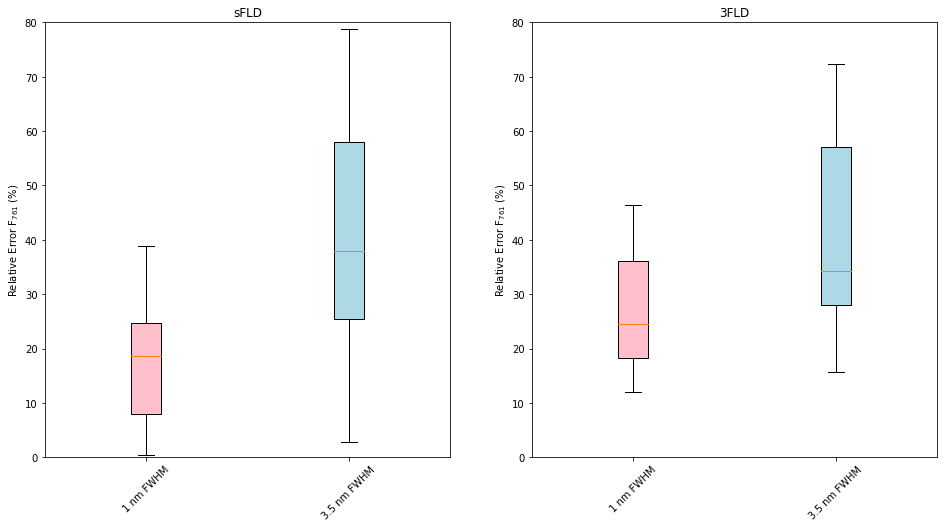

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))

labels = ['1 nm FWHM', '3.5 nm FWHM']

data1 = [sfld_rel_error, sfld_conv_rel_error]
data2 = [three_rel_error, three_conv_rel_error]

bplot1 = axes[0].boxplot(data1, vert = True, patch_artist = True, labels = labels, showfliers = False)

plt.xticks(rotation= 90)
axes[0].set_title('sFLD')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

axes[0].set_ylim(0, 80)
axes[0].set_ylabel('Relative Error F$_{761}$ (%)')

bplot2 = axes[1].boxplot(data2, notch = False, vert = True, patch_artist = True, labels = labels, showfliers = False)

axes[1].set_title('3FLD')

colors = ['pink', 'lightblue', 'lightgreen', 'k', 'r', 'g', 'm', 'y', 'w']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

axes[1].set_ylim(0, 80)
axes[1].set_ylabel('Relative Error F$_{761}$ (%)')

plt.show()

